# pooled

##### By: Paul Doan ([Google Scholar](https://scholar.google.com/citations?view_op=list_works&hl=en&hl=en&user=O4q49qQAAAAJ))


- A straight-forward Python workflow for wet-lab biologists to analyze pooled, functional genetic perturbation screens (e.g., CRISPR, RNAi, ORF) coupled with either viability or FACS-based readouts.

- The pre-processing and QC steps of this workflow and the data demo below are duplicated from the Broad GPP's `poola` Python package. Please check it out [here](https://pypi.org/project/poola/). 

- The main difference in this `pooled` workflow is in the p-value calculation step. `pooled` determines the p-value for each element (sgRNA, shRNA, or ORF barcode) by comparing its normalized log2-fold change (LFC) gene-level rank against a randomly-permuted null distribution of gene-level ranks, whereas `poola`'s Method 1 scales the LFC to a Gaussian distribution. This approach was previously implemented in `R` by Dr. Mikolaj Slabicki from Dr. Benjamin Ebert's lab @ Dana-Farber Cancer Institute ([Slabicki and Kozicka et al., 2020](https://pubmed.ncbi.nlm.nih.gov/32494016/)). Hence, the demo data below is from the paper's _genome-wide FACS-based CRISPR-Cas9 screen_ in HEK293T cell line engineered to express a GFP/mCherry reporter of *CCNK* a.k.a. cyclin K protein's stabiblity (Fig.  2G).  Special thanks to Dr. Slabicki whom generously made the original code and data were generously made available in the Method section.

- Special thanks to Dr. John Doench, Peter DeWeirdt, and Dr. Mudra Hegde (co-authors of `poola`) and the team at GPP for their commitment to open-source science. More extensive wet- and dry-lab GPP resources are available [here](https://portals.broadinstitute.org/gpp/public/).

## Steps:
0. Load sgRNA read counts
1. Transform read counts into log counts then normalize by the library read depth/size
2. Filter out sgRNAs that are not represented in the plasmid library
3. Calculate log2-fold change (LFC) within each replicate
4. Normalize LFC by negative control sgRNAs within each replicate
5. Average sgRNA-level across replicates
    1. Take the mean of sgRNA-level LFC across replicates
    2. Rank the normalized LFC of sgRNAs within each replicate. Then, sum sgRNA-level ranks across replicates
6. Gene-level:
    1. Calculate gene-level LFC as the mean of sgRNA-level LFC
    2. Calculate gene-level ranks as the median of sgRNA-level ranks
7. Randomly permute gene-level ranks to generate the null distribution of gene-level ranks
8. Derive the p-value for all genes by comparing against the null rank distribution. Adjust for multiple hypothesis testing by the Benjamini-Hochberg procedure
12. Visualization (Volcano plot, Hockey-stick plot)

In [1]:
from pooled import pooled
pooled.foo()

You have imported pooled!


In [2]:
import pandas as pd
import numpy as np
from statsmodels.stats.multitest import multipletests

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties, findfont
import gpplot
from adjustText import adjust_text

# Find the path to the Helvetica font
font_path = findfont(FontProperties(family='Helvetica'))
# Set titles and labels with Helvetica font
font_properties = FontProperties(fname=font_path, size=12)

## Step 0: Load count matrix and guide annotations

To demonstrate the functionality of this package, we'll use read counts [Slabicki and Kozicka et al., 2020](https://pubmed.ncbi.nlm.nih.gov/32494016/). Download the count table at this [link](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7486275/bin/NIHMS1589514-supplement-3.zip).

In [3]:
supp_reads = "./Data/Functional genomics data.xlsx"
read_counts = pd.read_excel(supp_reads,
                            sheet_name = "Read Counts GW FACS",
                            #names = ['sgRNA Sequence', 'pDNA', 'A375_RepA', 'A375_RepB'], 
                            engine='openpyxl')

guide_annotations = read_counts[["Gene","Sequence"]]

read_counts = read_counts.drop(["Gene"],axis = 1)

Preview the read count matrix:

In [4]:
read_counts

,Sequence,CCNKGFP_HEK293T_CR8_A_RepA,CCNKGFP_HEK293T_CR8_B_RepA,CCNKGFP_HEK293T_CR8_AB_RepA,CCNKGFP_HEK293T_CR8_D_RepA,CCNKGFP_HEK293T_CR8_A_RepB,CCNKGFP_HEK293T_CR8_B_RepB,CCNKGFP_HEK293T_CR8_AB_RepB,CCNKGFP_HEK293T_CR8_D_RepB,CCNKGFP_HEK293T_DMSO_A_RepA,CCNKGFP_HEK293T_DMSO_B_RepA,CCNKGFP_HEK293T_DMSO_AB_RepA,CCNKGFP_HEK293T_DMSO_D_RepA,CCNKGFP_HEK293T_DMSO_A_RepB,CCNKGFP_HEK293T_DMSO_B_RepB,CCNKGFP_HEK293T_DMSO_AB_RepB,CCNKGFP_HEK293T_DMSO_D_RepB
0,CATCTTCTTTCACCTGAACG,98,226,324,0,39,140,179,68,40,175,215,128,69,178,247,132
1,CTCCGGGGAGAACTCCGGCG,146,148,294,6,21,155,176,82,37,103,140,138,50,125,175,77
2,TCTCCATGGTGCATCAGCAC,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,TGGAAGTCCACTCCACTCAG,118,213,331,332,40,229,269,113,66,229,295,120,90,174,264,66
4,ACAGGAAGAATTCAGTTATG,180,215,395,114,0,160,160,98,85,142,227,161,96,210,306,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77436,TGCAAGGCTTGACCATCAGT,143,146,289,172,38,190,228,45,75,150,225,60,75,180,255,98
77437,ACAGACGATTGCTGTACTCG,55,104,159,0,0,105,105,37,15,94,109,21,44,91,135,31
77438,AGAGTATAACGATGTTCTTG,103,145,248,14,101,169,270,36,61,130,191,33,55,127,182,55
77439,GCAGAGTACCCGAGAATCAT,98,106,204,137,97,144,241,27,27,73,100,29,75,103,178,71


For some datasets, the count matrix might have missing values. We can avoid future errors by assinging to them a pseudocount of 1.

In [5]:
# impute Nan as 1
nan_count_per_column = read_counts.isna().sum()
print(nan_count_per_column)
read_counts = read_counts.fillna(1)

Sequence                        0
CCNKGFP_HEK293T_CR8_A_RepA      0
CCNKGFP_HEK293T_CR8_B_RepA      0
CCNKGFP_HEK293T_CR8_AB_RepA     0
CCNKGFP_HEK293T_CR8_D_RepA      0
CCNKGFP_HEK293T_CR8_A_RepB      0
CCNKGFP_HEK293T_CR8_B_RepB      0
CCNKGFP_HEK293T_CR8_AB_RepB     0
CCNKGFP_HEK293T_CR8_D_RepB      0
CCNKGFP_HEK293T_DMSO_A_RepA     0
CCNKGFP_HEK293T_DMSO_B_RepA     0
CCNKGFP_HEK293T_DMSO_AB_RepA    0
CCNKGFP_HEK293T_DMSO_D_RepA     0
CCNKGFP_HEK293T_DMSO_A_RepB     0
CCNKGFP_HEK293T_DMSO_B_RepB     0
CCNKGFP_HEK293T_DMSO_AB_RepB    0
CCNKGFP_HEK293T_DMSO_D_RepB     0
dtype: int64


Preview the gene-sgRNA sequence annotations:

In [6]:
guide_annotations

,Gene,Sequence
0,A1BG,CATCTTCTTTCACCTGAACG
1,A1BG,CTCCGGGGAGAACTCCGGCG
2,A1BG,TCTCCATGGTGCATCAGCAC
3,A1BG,TGGAAGTCCACTCCACTCAG
4,A1CF,ACAGGAAGAATTCAGTTATG
...,...,...
77436,ZZEF1,TGCAAGGCTTGACCATCAGT
77437,ZZZ3,ACAGACGATTGCTGTACTCG
77438,ZZZ3,AGAGTATAACGATGTTCTTG
77439,ZZZ3,GCAGAGTACCCGAGAATCAT


## Step 1: Log-norm transform read counts

Due to differences between sequencing runs and sgRNA representation,
we log-normalize the read counts. First,
for each sgRNA we take the number of reads divided by the total number of reads in a given condition
$$\frac{\text{reads}}{\text{total reads in condition}}.$$

Since read counts tend to have a right skew, we also want to take the $\log_2$ of
these fractional abundances. Finally, since it is possible to have 0 reads and $\log_2(0)$ is undefined,
we multiply the fractional abundance by $1e6$ and add a pseudocount of 1 for our final equation

$$ \text{lognorm} = \log2\bigg(\frac{\text{reads}}{\text{total reads in condition}} \times 1e6 + 1 \bigg).$$

We can this equation as a function.

In [7]:
# List all the condition_replicate columns
condition_columns = read_counts.columns[1:].to_list()

# Apply the log-norm transformation
lognorm_df = read_counts.copy()
lognorm_df[condition_columns] = lognorm_df[condition_columns].apply(pooled.lognorm)

# Preview
lognorm_df

,Sequence,CCNKGFP_HEK293T_CR8_A_RepA,CCNKGFP_HEK293T_CR8_B_RepA,CCNKGFP_HEK293T_CR8_AB_RepA,CCNKGFP_HEK293T_CR8_D_RepA,CCNKGFP_HEK293T_CR8_A_RepB,CCNKGFP_HEK293T_CR8_B_RepB,CCNKGFP_HEK293T_CR8_AB_RepB,CCNKGFP_HEK293T_CR8_D_RepB,CCNKGFP_HEK293T_DMSO_A_RepA,CCNKGFP_HEK293T_DMSO_B_RepA,CCNKGFP_HEK293T_DMSO_AB_RepA,CCNKGFP_HEK293T_DMSO_D_RepA,CCNKGFP_HEK293T_DMSO_A_RepB,CCNKGFP_HEK293T_DMSO_B_RepB,CCNKGFP_HEK293T_DMSO_AB_RepB,CCNKGFP_HEK293T_DMSO_D_RepB
0,CATCTTCTTTCACCTGAACG,4.294138,4.687031,4.555412,0.000000,2.899097,3.998626,3.659722,4.017112,3.663159,4.252072,4.119864,4.827359,3.979261,4.279016,4.188026,4.603701
1,CTCCGGGGAGAACTCCGGCG,4.844871,4.105524,4.421481,1.029640,2.162932,4.136707,3.637282,4.271907,3.559888,3.539340,3.544737,4.932197,3.548940,3.800237,3.723073,3.867866
2,TCTCCATGGTGCATCAGCAC,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,TGGAAGTCCACTCCACTCAG,4.549553,4.604976,4.584951,5.873580,2.930779,4.673036,4.208661,4.713900,4.340050,4.622099,4.553562,4.737634,4.341086,4.247934,4.278947,3.661850
4,ACAGGAAGAATTCAGTTATG,5.137386,4.617907,4.830200,4.377734,0.000000,4.179945,3.511327,4.516820,4.689036,3.968097,4.193827,5.147823,4.429740,4.506160,4.481705,4.472119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77436,TGCAAGGCTTGACCATCAGT,4.815971,4.087043,4.397899,4.947515,2.866702,4.415250,3.984052,3.466341,4.515901,4.042244,4.181760,3.790721,4.092218,4.294310,4.231527,4.194457
77437,ACAGACGATTGCTGTACTCG,3.517165,3.631539,3.590751,0.000000,0.000000,3.613364,2.968439,3.211890,2.426436,3.419260,3.218375,2.457812,3.381228,3.380430,3.380690,2.694925
77438,AGAGTATAACGATGTTCTTG,4.362354,4.077713,4.188439,1.778294,4.148014,4.254651,4.213725,3.176681,4.232221,3.849202,3.959489,3.011089,3.675194,3.821505,3.775448,3.421434
77439,GCAGAGTACCCGAGAATCAT,4.294138,3.656822,3.923635,4.631178,4.093067,4.036759,4.059125,2.813870,3.149934,3.092778,3.107931,2.849151,4.092218,3.542905,3.745753,3.759153


## Step 2: Filter out underrepresented sgRNA

Sometimes the cloning process can fail to capture an sgRNA sequence in the plasmid pool, so we remove plasmids that are not well represented in the pool.

To decide which sgRNAs are underrepresented, we z-score the pDNA log-norms and remove any sgRNAs with a z-score less than -3.

$$ \text{z-score} = \bigg(\frac{\text{lognorm of sgRNA} - \text{mean of all sgRNA lognorms}}{\text{std dev of all sgRNA lognorms}} \bigg)$$


Unfortunately, the pDNA count is not available for this specific dataset so we will simply skip. However, if the code to do so is available here.

In [8]:
#### ONLY RUN if there is pDNA #####
# Initialize
#filtered_lognorms = lognorm_df.copy()
#pdna_cols = ['pDNA']

# Apply filter function
#filtered_lognorms = pooled.filter_pDNA(filtered_lognorms, pdna_cols, z_low = -3)

# Preview
#filtered_lognorms

In [9]:
filtered_lognorms = lognorm_df.copy()

## Step 3: Calculate LFC

To understand how sgRNA abundance has changed between the target and the reference samples of the screen, we take 

$$\text{log2-fold change} = \text{target lognorm} - \text{reference lognorm}.$$

Where 
- the `reference lognorm` is the filtered, lognormed reads from a reference condition such as initial pDNA/T0, DMSO-treated, or the low GFP fraction sample
- the `target lognorm` is the filtered, lognormed reads from the endpoint, drug-treated, or the high GFP fraction sample

In this example, we will define a reference map to match cells in the *AB* FACS fraction to the *D* FACS fraction within each replicate.

In [10]:
# Again, here are all the condition_replicate columns. We will only look at 4 for the demo.
condition_columns

['CCNKGFP_HEK293T_CR8_A_RepA',
 'CCNKGFP_HEK293T_CR8_B_RepA',
 'CCNKGFP_HEK293T_CR8_AB_RepA',
 'CCNKGFP_HEK293T_CR8_D_RepA',
 'CCNKGFP_HEK293T_CR8_A_RepB',
 'CCNKGFP_HEK293T_CR8_B_RepB',
 'CCNKGFP_HEK293T_CR8_AB_RepB',
 'CCNKGFP_HEK293T_CR8_D_RepB',
 'CCNKGFP_HEK293T_DMSO_A_RepA',
 'CCNKGFP_HEK293T_DMSO_B_RepA',
 'CCNKGFP_HEK293T_DMSO_AB_RepA',
 'CCNKGFP_HEK293T_DMSO_D_RepA',
 'CCNKGFP_HEK293T_DMSO_A_RepB',
 'CCNKGFP_HEK293T_DMSO_B_RepB',
 'CCNKGFP_HEK293T_DMSO_AB_RepB',
 'CCNKGFP_HEK293T_DMSO_D_RepB']

In [11]:
# Key-value pair defining the contrasts.  
## Target lognorm is key and Reference lognorm is value
ref_map = {
    'CCNKGFP_HEK293T_CR8_AB_RepA':  'CCNKGFP_HEK293T_CR8_D_RepA',
    'CCNKGFP_HEK293T_CR8_AB_RepB':  'CCNKGFP_HEK293T_CR8_D_RepB'
          }

Now, we can calculate the LFC based on the formula above.

In [12]:
# Initialize
lfc_df = filtered_lognorms.copy()

# Calculate LFC
lfc_df = pooled.calculate_LFC(lfc_df, filtered_lognorms, ref_map)

# Preview
lfc_df

,Sequence,CCNKGFP_HEK293T_CR8_AB_RepA_v_CCNKGFP_HEK293T_CR8_D_RepA,CCNKGFP_HEK293T_CR8_AB_RepB_v_CCNKGFP_HEK293T_CR8_D_RepB
0,CATCTTCTTTCACCTGAACG,4.555412,-0.357390
1,CTCCGGGGAGAACTCCGGCG,3.391841,-0.634625
2,TCTCCATGGTGCATCAGCAC,0.000000,0.000000
3,TGGAAGTCCACTCCACTCAG,-1.288629,-0.505238
4,ACAGGAAGAATTCAGTTATG,0.452466,-1.005494
...,...,...,...
77436,TGCAAGGCTTGACCATCAGT,-0.549616,0.517712
77437,ACAGACGATTGCTGTACTCG,3.590751,-0.243451
77438,AGAGTATAACGATGTTCTTG,2.410146,1.037045
77439,GCAGAGTACCCGAGAATCAT,-0.707543,1.245255


## Optional: Check replicate correlation

We can check how well the replicates correlate with one another by using the `corr()` function to calculate R2 value and display in a heatmap

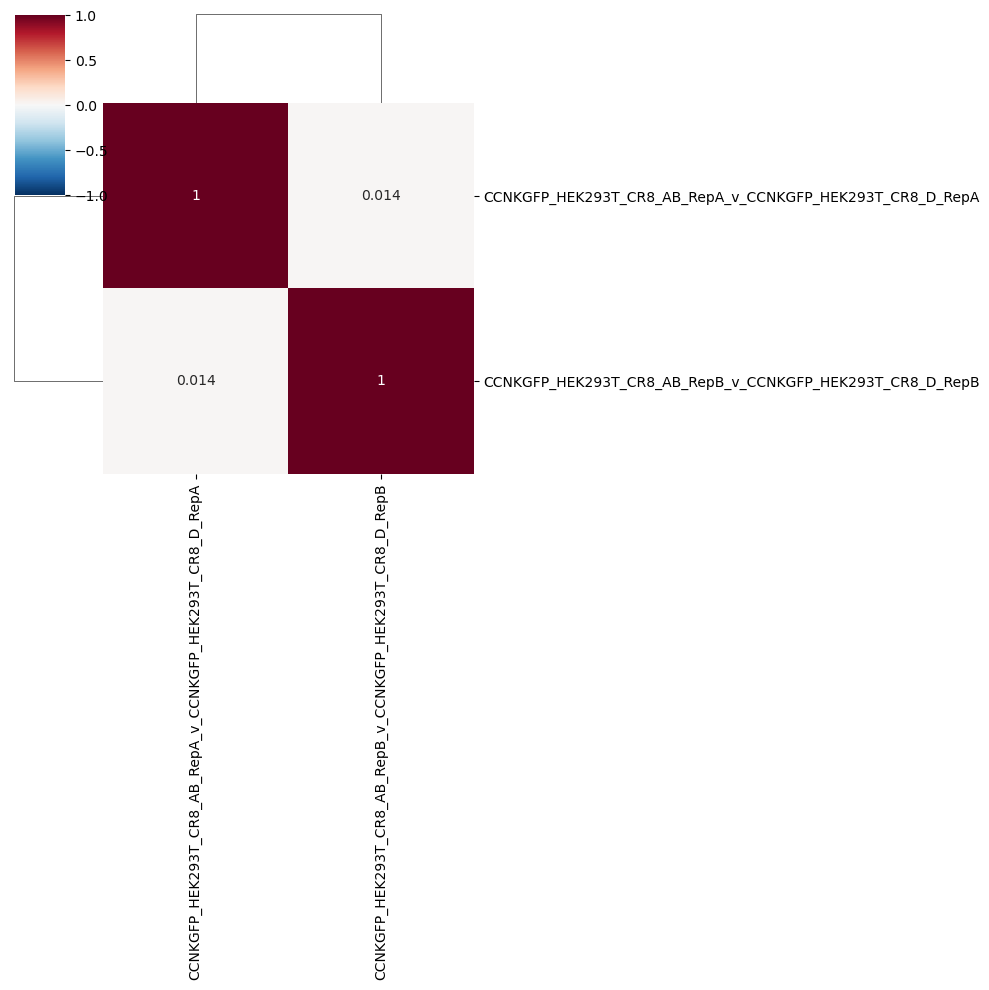

In [13]:
lfc_correlations = lfc_df.iloc[:,1:].corr()
sns.clustermap(lfc_correlations, cmap='RdBu_r',
               vmin=-1, vmax=1, annot=True)

Alternatively, we can check the scatterplot distribution between 2 replicates

/Users/paul/anaconda3/envs/pooled/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/paul/anaconda3/envs/pooled/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/paul/anaconda3/envs/pooled/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


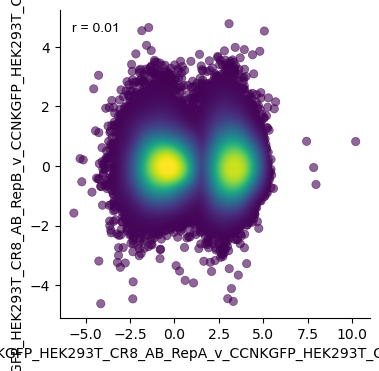

In [14]:
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=lfc_df, x='CCNKGFP_HEK293T_CR8_AB_RepA_v_CCNKGFP_HEK293T_CR8_D_RepA', y='CCNKGFP_HEK293T_CR8_AB_RepB_v_CCNKGFP_HEK293T_CR8_D_RepB')
gpplot.add_correlation(data=lfc_df, x='CCNKGFP_HEK293T_CR8_AB_RepA_v_CCNKGFP_HEK293T_CR8_D_RepA', y='CCNKGFP_HEK293T_CR8_AB_RepB_v_CCNKGFP_HEK293T_CR8_D_RepB')
sns.despine()

## Pivot the dataframe from wide to long format

In [15]:
# Map the condition
condition_map = {'CCNKGFP_HEK293T_CR8_AB_RepA_v_CCNKGFP_HEK293T_CR8_D_RepA': 'CCNKGFP_HEK293T_CR8',
                 'CCNKGFP_HEK293T_CR8_AB_RepB_v_CCNKGFP_HEK293T_CR8_D_RepB': 'CCNKGFP_HEK293T_CR8'
                }

# Map the replicates
rep_map = {'CCNKGFP_HEK293T_CR8_AB_RepA_v_CCNKGFP_HEK293T_CR8_D_RepA': "RepA",
           'CCNKGFP_HEK293T_CR8_AB_RepB_v_CCNKGFP_HEK293T_CR8_D_RepB': "RepB"
          }

In [16]:
long_lfcs = pooled.pivot(lfc_df, condition_map, rep_map)
# Preview
long_lfcs

,Sequence,condition,lfc,Rep
0,CATCTTCTTTCACCTGAACG,CCNKGFP_HEK293T_CR8,4.555412,RepA
1,CTCCGGGGAGAACTCCGGCG,CCNKGFP_HEK293T_CR8,3.391841,RepA
2,TCTCCATGGTGCATCAGCAC,CCNKGFP_HEK293T_CR8,0.000000,RepA
3,TGGAAGTCCACTCCACTCAG,CCNKGFP_HEK293T_CR8,-1.288629,RepA
4,ACAGGAAGAATTCAGTTATG,CCNKGFP_HEK293T_CR8,0.452466,RepA
...,...,...,...,...
154877,TGCAAGGCTTGACCATCAGT,CCNKGFP_HEK293T_CR8,0.517712,RepB
154878,ACAGACGATTGCTGTACTCG,CCNKGFP_HEK293T_CR8,-0.243451,RepB
154879,AGAGTATAACGATGTTCTTG,CCNKGFP_HEK293T_CR8,1.037045,RepB
154880,GCAGAGTACCCGAGAATCAT,CCNKGFP_HEK293T_CR8,1.245255,RepB


## Merge with sgRNA annotations

In [17]:
annotated_sgrna_lfcs = pooled.annotate(long_lfcs, guide_annotations)
# Preview
annotated_sgrna_lfcs

,Sequence,condition,lfc,Rep,Gene
0,CATCTTCTTTCACCTGAACG,CCNKGFP_HEK293T_CR8,4.555412,RepA,A1BG
1,CATCTTCTTTCACCTGAACG,CCNKGFP_HEK293T_CR8,-0.357390,RepB,A1BG
2,CTCCGGGGAGAACTCCGGCG,CCNKGFP_HEK293T_CR8,3.391841,RepA,A1BG
3,CTCCGGGGAGAACTCCGGCG,CCNKGFP_HEK293T_CR8,-0.634625,RepB,A1BG
4,TCTCCATGGTGCATCAGCAC,CCNKGFP_HEK293T_CR8,0.000000,RepA,A1BG
...,...,...,...,...,...
154877,AGAGTATAACGATGTTCTTG,CCNKGFP_HEK293T_CR8,1.037045,RepB,ZZZ3
154878,GCAGAGTACCCGAGAATCAT,CCNKGFP_HEK293T_CR8,-0.707543,RepA,ZZZ3
154879,GCAGAGTACCCGAGAATCAT,CCNKGFP_HEK293T_CR8,1.245255,RepB,ZZZ3
154880,TCAATTGCCTGAGATCGTAT,CCNKGFP_HEK293T_CR8,-0.377400,RepA,ZZZ3


It's helpful to see the raw distribution of sgRNA-level LFCs in a histogram

/Users/paul/anaconda3/envs/pooled/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/paul/anaconda3/envs/pooled/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/paul/anaconda3/envs/pooled/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/paul/anaconda3/envs/pooled/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future v

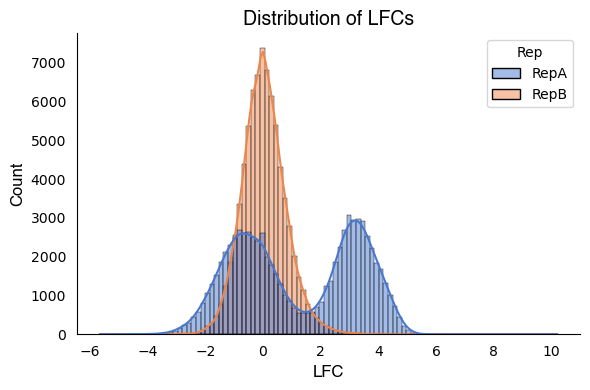

In [18]:
pooled.plot_histogram(annotated_sgrna_lfcs, 
                      col="lfc", 
                      hue="Rep", 
                      title="Distribution of LFCs", 
                      xlabel="LFC", 
                      ylabel="Count", 
                      figsize=(6,4), 
                      bins=100)

## Step 4: Normalize LFC by negative control sgRNAs

Now, let's look at how the negative control sgRNAs perform. *Remember*, these are the sgRNAs that are expected to have no impact (LFC ~ 0)

In [19]:
# Specify the genes that serve as negative control
negative_ctrl_genes = ['Non-Targeting Control']

# Calculate summary statistics on negative control sgRNAs
control_sgrna_lfcs, control_sgrna_stats = pooled.calculate_control_sgRNA_stats(annotated_sgrna_lfcs, negative_ctrl_genes)

In [20]:
control_sgrna_lfcs

,Sequence,condition,lfc,Rep,Gene
0,AAAAAGCTTCCGCCTGATGG,CCNKGFP_HEK293T_CR8,-0.889376,RepA,Non-Targeting Control
1,AAAAAGCTTCCGCCTGATGG,CCNKGFP_HEK293T_CR8,-0.030299,RepB,Non-Targeting Control
2,AAAACAGGACGATGTGCGGC,CCNKGFP_HEK293T_CR8,-0.454637,RepA,Non-Targeting Control
3,AAAACAGGACGATGTGCGGC,CCNKGFP_HEK293T_CR8,-0.094706,RepB,Non-Targeting Control
4,AAAACATCGACCGAAAGCGT,CCNKGFP_HEK293T_CR8,3.950622,RepA,Non-Targeting Control
...,...,...,...,...,...
1995,TTTTGACTCTAATCACCGGT,CCNKGFP_HEK293T_CR8,-0.607230,RepB,Non-Targeting Control
1996,TTTTTAATACAAGGTAATCT,CCNKGFP_HEK293T_CR8,0.035853,RepA,Non-Targeting Control
1997,TTTTTAATACAAGGTAATCT,CCNKGFP_HEK293T_CR8,-0.418833,RepB,Non-Targeting Control
1998,TTTTTCTCACCCGATGAATC,CCNKGFP_HEK293T_CR8,-1.559399,RepA,Non-Targeting Control


In [21]:
control_sgrna_stats

,condition,Rep,neg_ctl_mean,neg_ctl_sd
0,CCNKGFP_HEK293T_CR8,RepA,0.842549,1.951163
1,CCNKGFP_HEK293T_CR8,RepB,0.011128,0.542981


Let's also look at the shape of their distribution

/Users/paul/anaconda3/envs/pooled/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/paul/anaconda3/envs/pooled/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/paul/anaconda3/envs/pooled/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/paul/anaconda3/envs/pooled/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future v

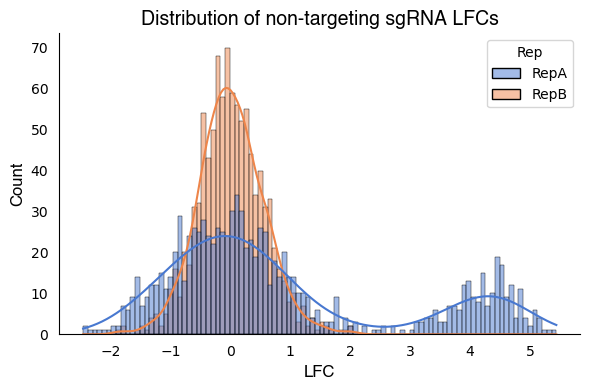

In [22]:
pooled.plot_histogram(control_sgrna_lfcs, 
                      col="lfc", 
                      hue="Rep", 
                      title="Distribution of non-targeting sgRNA LFCs", 
                      xlabel="LFC", 
                      ylabel="Count", 
                      figsize=(6,4), 
                      bins=100)

Here, we will use the function `calculate_sgRNA_LFCs()` to:
1) Normalize the filtered sgRNA-level LFCs by the mean of LFC of the negative control sgRNAs (stored in `control_sgrna_stats[neg_ctl_mean]`) within each replicate: `norm_lfc`
2) Rank the filtered, normalized sgRNA-level LFCs within each replicate: `sgRNA_Rank`
3) Combine the replicates:
    1) `norm_avg_lfc` = mean across all replicates' `norm_lfc`
    2) `sgRNA_sum_Rank` = sum across all replicates' `sgRNA_Rank`

In [23]:
NTC_norm_avg_sgrna_lfcs = pooled.calculate_sgRNA_LFCs(annotated_sgrna_lfcs, control_sgrna_stats, guide_annotations, return_tmp=False)

By default, `calculate_sgRNA_LFCs()` will only return the final dataframe called `NTC_norm_avg_sgrna_lfcs`. You can check out the intermediate dataframe by setting `return_tmp=True`.

In [24]:
NTC_norm_avg_sgrna_lfcs

,Sequence,condition,norm_avg_lfc,sgRNA_sum_Rank,Gene
0,AAAAAAAATCCGGACAATGG,CCNKGFP_HEK293T_CR8,1.561666,44343,SLC25A24
1,AAAAAAAGGATGGTGATCAA,CCNKGFP_HEK293T_CR8,-0.610295,88747,FASTKD3
2,AAAAAAATGACATTACTGCA,CCNKGFP_HEK293T_CR8,1.703777,40466,BCAS2
3,AAAAAAATGTCAGTCGAGTG,CCNKGFP_HEK293T_CR8,0.593377,93185,GPR18
4,AAAAAACACAAGCAAGACCG,CCNKGFP_HEK293T_CR8,-1.859416,136974,ZNF470
...,...,...,...,...,...
77436,TTTGTTTGGATTGCTTCAAG,CCNKGFP_HEK293T_CR8,0.029783,72054,C3orf17
77437,TTTTACCTTGTTCACATGGA,CCNKGFP_HEK293T_CR8,-0.475358,88536,Non-Targeting Control
77438,TTTTGACTCTAATCACCGGT,CCNKGFP_HEK293T_CR8,-1.150959,123882,Non-Targeting Control
77439,TTTTTAATACAAGGTAATCT,CCNKGFP_HEK293T_CR8,-0.618329,103284,Non-Targeting Control


We will now calculate gene-level LFCs and ranks by invoking the function `calculate_gene_LFCs()`:

- `gene_norm_avg_lfc` is the mean of sgRNA-level LFCs
- `gene_Rank` is the median of sgRNA-level rank
- `n_sgrnas` is the number of sgRNAs contributing to that gene's stats

In [25]:
NTC_norm_gene_lfcs = pooled.calculate_gene_LFCs(NTC_norm_avg_sgrna_lfcs)
# Preview
NTC_norm_gene_lfcs

,Gene,condition,gene_norm_avg_lfc,gene_Rank,n_sgrnas
0,A1BG,CCNKGFP_HEK293T_CR8,0.218333,82263.0,4
1,A1CF,CCNKGFP_HEK293T_CR8,0.036441,87512.0,4
2,A2M,CCNKGFP_HEK293T_CR8,-0.119780,83251.0,4
3,A2ML1,CCNKGFP_HEK293T_CR8,-0.616280,86406.0,4
4,A3GALT2,CCNKGFP_HEK293T_CR8,0.835349,53539.0,4
...,...,...,...,...,...
19108,ZYG11A,CCNKGFP_HEK293T_CR8,0.698849,47638.5,4
19109,ZYG11B,CCNKGFP_HEK293T_CR8,0.701252,41948.5,4
19110,ZYX,CCNKGFP_HEK293T_CR8,0.085120,86473.5,4
19111,ZZEF1,CCNKGFP_HEK293T_CR8,-0.373929,73439.5,4


/Users/paul/anaconda3/envs/pooled/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/paul/Dropbox (Harvard University)/PAUL SHARED/pooled/pooled/pooled.py:108: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=dataframe, x=col, kde=True, hue=hue, bins=bins, palette='muted')
/Users/paul/anaconda3/envs/pooled/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


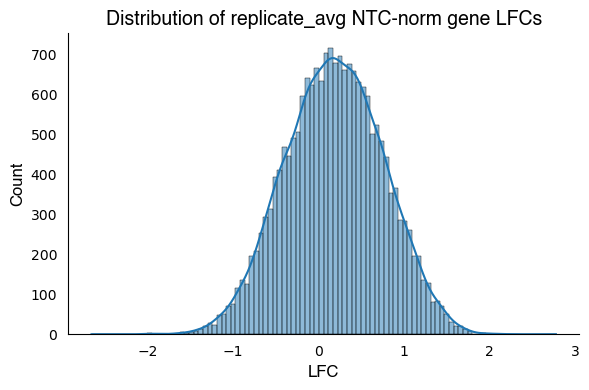

In [26]:
pooled.plot_histogram(NTC_norm_gene_lfcs, 
                      col="gene_norm_avg_lfc", 
                      hue=None, 
                      title='Distribution of replicate_avg NTC-norm gene LFCs', 
                      xlabel="LFC", 
                      ylabel="Count", 
                      figsize=(6,4), 
                      bins=100)

## Step 5: Permute to generate null distribution

To calculate the p-value, we will first generate a null rank distribution of `gene_Rank` which randomly shuffles the `sgRNA_sum_Rank` by invoking the function `simulate_p_value()`

In [27]:
null_rank_df, null_rank_vector,len_null_rank_vector = pooled.simulate_p_value(NTC_norm_avg_sgrna_lfcs, 
                                                                               n_reps = 2, 
                                                                               n_iterations=500, 
                                                                               seed = 31800) # seed for reproducibility
# Save the null-rank matrix
null_rank_df.to_csv("out/Ebert_null_rank_matrix.csv")
# Preview
null_rank_df

/Users/paul/Dropbox (Harvard University)/PAUL SHARED/pooled/pooled/pooled.py:200: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  total_sgRNAs = int(NTC_norm_avg_sgrna_lfcs.groupby('condition').count()['Sequence'])


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,67422.5,86126.5,42882.0,66282.0,95450.5,89008.5,74147.5,85993.0,106691.0,67218.0,...,66807.5,89528.5,77743.5,74055.5,52484.0,34274.0,101902.0,93337.0,77161.0,77936.0
1,69006.5,67746.0,88920.5,18648.0,126831.0,94163.5,49046.5,76682.5,56142.5,89885.0,...,80266.0,82152.0,53512.5,88257.0,48295.5,97707.0,80703.5,100850.5,56522.5,57136.0
2,67682.0,86663.0,73631.0,94047.5,100768.0,58108.0,69193.0,60852.5,119465.0,91499.5,...,71753.0,65469.5,74623.0,71186.5,56301.0,78532.0,87051.5,92253.5,52681.0,78110.0
3,76889.5,89263.5,59681.5,108129.5,56884.5,91004.5,75716.0,73856.5,95150.5,75433.5,...,129151.0,66738.5,83191.5,60382.5,95517.0,106937.5,31512.5,82328.0,98137.5,96623.0
4,94522.5,103029.0,110139.5,49331.0,87911.5,58713.5,79780.0,74862.0,87928.0,59514.0,...,54869.0,64311.5,74434.5,42684.0,64270.0,39333.0,75807.0,74519.5,53179.5,86769.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19108,87125.5,53784.5,99378.5,78983.0,92331.5,83445.0,108932.0,34690.0,95976.5,57639.5,...,65772.5,113211.0,74715.5,81123.5,86459.0,104037.5,71696.0,70157.5,77464.5,88217.0
19109,115451.5,80830.5,66188.0,82487.5,79485.5,74803.0,58313.5,97289.0,75358.5,61055.0,...,64615.0,79678.5,75072.5,63512.5,61064.5,64350.0,81937.0,112623.0,64731.0,60376.5
19110,96783.0,94001.0,67363.0,86496.0,77342.0,65384.5,71633.0,107881.5,77632.0,69976.0,...,87848.5,66105.5,86496.5,69184.5,74501.0,65786.0,76316.5,59061.0,68867.5,79386.0
19111,67982.0,78027.0,74350.5,102370.5,120031.0,67439.5,80907.0,82492.5,68733.5,51960.0,...,75054.0,93725.5,77887.0,77967.5,101883.5,100880.0,98825.5,67090.0,90958.0,49491.0


Let's see what the null rank distribution looks like!

/Users/paul/anaconda3/envs/pooled/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/paul/anaconda3/envs/pooled/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/paul/anaconda3/envs/pooled/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/paul/anaconda3/envs/pooled/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in 

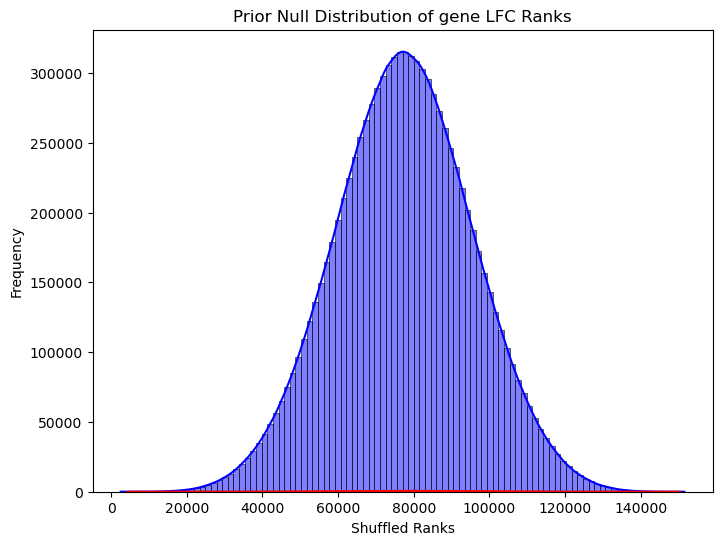

In [28]:
plt.figure(figsize=(8, 6))
sns.histplot(null_rank_vector, 
             kde=True, color='blue', bins=100)
sns.histplot(NTC_norm_gene_lfcs["gene_Rank"],kde=True, color='red', bins = 100)
plt.xlabel('Shuffled Ranks')
plt.ylabel('Frequency')
plt.title('Prior Null Distribution of gene LFC Ranks')
plt.show()

## Calculate p-values

Great! Now we can calculate the `p-value` for each gene. *Recall* the definition of `p-value`

$$ \text{p-value} = \bigg(\frac{\text{number of permuted ranks as extreme as the observed rank}}{\text{total number of permuted ranks}} \bigg)$$

And since we are testing for ~20,000 genes all at once, we need to correct for multiple hypothesis testing using *Benjamini-Hochberg* procedure to adjust `p-value` to get `FDR`


In [29]:
NTC_norm_gene_lfcs_adjpval = pooled.calculate_p_value(NTC_norm_gene_lfcs, null_rank_vector, len_null_rank_vector, significant_threshold=0.05)

# Save
NTC_norm_gene_lfcs_adjpval.to_csv("out/Ebert_pooled_NTC_norm_gene_lfc.csv")

# Preview
NTC_norm_gene_lfcs_adjpval.sort_values(by='FDR').head(n=20)

/Users/paul/Dropbox (Harvard University)/PAUL SHARED/pooled/pooled/pooled.py:255: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NTC_norm_gene_lfcs_pval['nlog10pval'][NTC_norm_gene_lfcs_pval['nlog10pval'] == np.inf] = max_value
/Users/paul/Dropbox (Harvard University)/PAUL SHARED/pooled/pooled/pooled.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NTC_norm_gene_lfcs_adjpval['nlog10FDR'][NTC_norm_gene_lfcs_adjpval['nlog10FDR'] == np.inf] = max_value


Number of significant hits at FDR = 0.05 is 9


,Gene,condition,gene_norm_avg_lfc,gene_Rank,n_sgrnas,pval,nlog10pval,significant,FDR,nlog10FDR
4208,DDB1,CCNKGFP_HEK293T_CR8,-1.910120,150390.0,4,2.092816e-07,6.679269,True,0.001600,2.795880
17926,VCP,CCNKGFP_HEK293T_CR8,-2.317884,149318.0,4,4.185633e-07,6.378239,True,0.001600,2.795880
13071,PSMA6,CCNKGFP_HEK293T_CR8,-2.484089,150038.5,4,4.185633e-07,6.378239,True,0.001600,2.795880
510,AKIRIN2,CCNKGFP_HEK293T_CR8,-1.861435,149510.0,4,4.185633e-07,6.378239,True,0.001600,2.795880
2679,CCNK,CCNKGFP_HEK293T_CR8,2.774667,4241.0,4,4.185633e-07,6.378239,True,0.001600,2.795880
11616,OTUD5,CCNKGFP_HEK293T_CR8,-2.652473,147741.0,4,2.302098e-06,5.637876,True,0.007333,2.134699
4264,DDX6,CCNKGFP_HEK293T_CR8,-1.223990,147455.0,4,2.929943e-06,5.533141,True,0.008000,2.096910
12471,PML,CCNKGFP_HEK293T_CR8,1.618705,9801.0,4,1.004552e-05,4.998028,True,0.024000,1.619789
2883,CDK12,CCNKGFP_HEK293T_CR8,-1.960686,143683.0,4,2.155601e-05,4.666432,True,0.045778,1.339345
19078,ZSCAN2,CCNKGFP_HEK293T_CR8,1.507388,12256.5,4,3.913567e-05,4.407427,False,0.074800,1.126098


## Visualization

We're almost there! Typical publication-ready plots for a CRISPR screen are a volcano plot and a hockey-stick plot.

We will plot both after we preview what the statistically significant hits are:

In [30]:
sub = NTC_norm_gene_lfcs_adjpval[NTC_norm_gene_lfcs_adjpval['condition'] == 'CCNKGFP_HEK293T_CR8']
sub = sub[sub['significant'] == True]
sub

,Gene,condition,gene_norm_avg_lfc,gene_Rank,n_sgrnas,pval,nlog10pval,significant,FDR,nlog10FDR
510,AKIRIN2,CCNKGFP_HEK293T_CR8,-1.861435,149510.0,4,4.185633e-07,6.378239,True,0.001600,2.795880
2679,CCNK,CCNKGFP_HEK293T_CR8,2.774667,4241.0,4,4.185633e-07,6.378239,True,0.001600,2.795880
2883,CDK12,CCNKGFP_HEK293T_CR8,-1.960686,143683.0,4,2.155601e-05,4.666432,True,0.045778,1.339345
4208,DDB1,CCNKGFP_HEK293T_CR8,-1.910120,150390.0,4,2.092816e-07,6.679269,True,0.001600,2.795880
4264,DDX6,CCNKGFP_HEK293T_CR8,-1.223990,147455.0,4,2.929943e-06,5.533141,True,0.008000,2.096910
11616,OTUD5,CCNKGFP_HEK293T_CR8,-2.652473,147741.0,4,2.302098e-06,5.637876,True,0.007333,2.134699
12471,PML,CCNKGFP_HEK293T_CR8,1.618705,9801.0,4,1.004552e-05,4.998028,True,0.024000,1.619789
13071,PSMA6,CCNKGFP_HEK293T_CR8,-2.484089,150038.5,4,4.185633e-07,6.378239,True,0.001600,2.795880
17926,VCP,CCNKGFP_HEK293T_CR8,-2.317884,149318.0,4,4.185633e-07,6.378239,True,0.001600,2.795880


### Volcano Plot

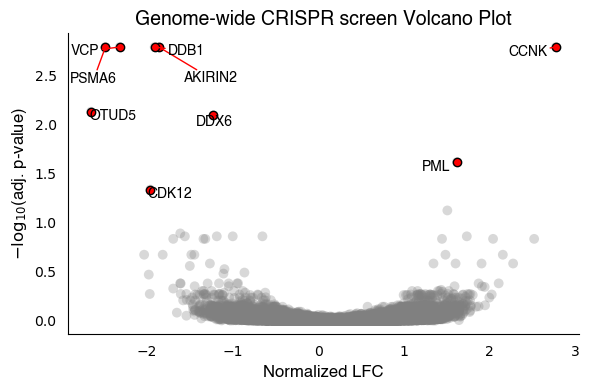

In [31]:
df = NTC_norm_gene_lfcs_adjpval.copy()
x = df["gene_norm_avg_lfc"]
y = df["nlog10FDR"]
labels = df["Gene"]
significant_genes_to_label = df.loc[df["significant"] == True]["Gene"].tolist()


pooled.plot_scatter(df, x, y, labels, significant_genes_to_label,
                   title = 'Genome-wide CRISPR screen Volcano Plot',
                    xlabel = 'Normalized LFC',
                    ylabel = '$-\mathrm{log_{10}}$(adj. p-value)')

### Hockey-stick Plot

In [32]:
NTC_norm_gene_lfcs_adjpval['Plot_Rank'] = NTC_norm_gene_lfcs_adjpval.groupby(['condition'])['gene_norm_avg_lfc'].rank(ascending=True, method='min').astype(int)
NTC_norm_gene_lfcs_adjpval

,Gene,condition,gene_norm_avg_lfc,gene_Rank,n_sgrnas,pval,nlog10pval,significant,FDR,nlog10FDR,Plot_Rank
0,A1BG,CCNKGFP_HEK293T_CR8,0.218333,82263.0,4,0.789255,0.102783,False,0.992753,0.003159,9942
1,A1CF,CCNKGFP_HEK293T_CR8,0.036441,87512.0,4,0.578016,0.238060,False,0.989653,0.004517,7631
2,A2M,CCNKGFP_HEK293T_CR8,-0.119780,83251.0,4,0.747529,0.126372,False,0.989653,0.004517,5750
3,A2ML1,CCNKGFP_HEK293T_CR8,-0.616280,86406.0,4,0.620183,0.207480,False,0.989653,0.004517,1550
4,A3GALT2,CCNKGFP_HEK293T_CR8,0.835349,53539.0,4,0.189996,0.721255,False,0.948842,0.022806,16600
...,...,...,...,...,...,...,...,...,...,...,...
19108,ZYG11A,CCNKGFP_HEK293T_CR8,0.698849,47638.5,4,0.101842,0.992072,False,0.903394,0.044123,15448
19109,ZYG11B,CCNKGFP_HEK293T_CR8,0.701252,41948.5,4,0.050433,1.297282,False,0.848354,0.071423,15472
19110,ZYX,CCNKGFP_HEK293T_CR8,0.085120,86473.5,4,0.617527,0.209344,False,0.989653,0.004517,8234
19111,ZZEF1,CCNKGFP_HEK293T_CR8,-0.373929,73439.5,4,0.824714,0.083697,False,0.994367,0.002453,3283


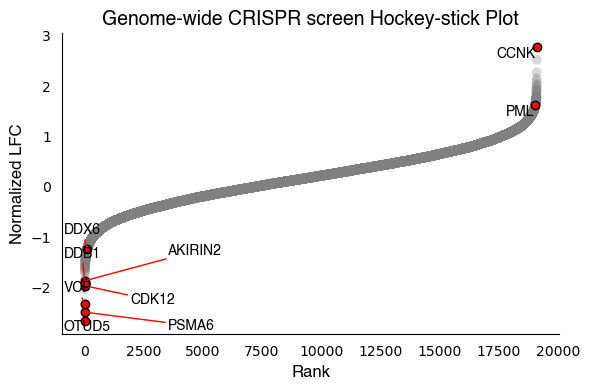

In [33]:
df = NTC_norm_gene_lfcs_adjpval.copy()
x = df["Plot_Rank"]
y = df["gene_norm_avg_lfc"]
labels = df["Gene"]
significant_genes_to_label = df.loc[df["significant"] == True]["Gene"].tolist()


pooled.plot_scatter(df, x, y, labels, significant_genes_to_label,
                   title = 'Genome-wide CRISPR screen Hockey-stick Plot',
                    xlabel = 'Rank',
                    ylabel = 'Normalized LFC')

-----

# Fin!
You can leave your questions in the Github repo's Pull Request section of this package